In [1]:
from tensorflow import keras
import tensorflow as tf 
import sys, datetime 
import pickle, json, os, shutil, tqdm, string
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.utils import load_img 
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import configs
from customized import *

2022-11-08 17:50:19.018009: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from PIL import Image
from keras import layers, Sequential
from keras.models import Model

from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization,\
    UpSampling2D, Add, Activation, GlobalAveragePooling2D, Flatten, Concatenate

from keras.layers import RandomRotation, RandomZoom, CenterCrop, \
    RandomContrast, RandomCrop, RandomTranslation, Rescaling, Resizing

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## Explore data

In [4]:
data_dir = './data/indoorCVPR_09/Images/'

In [5]:
base_dir = './data/'

In [6]:
classes = []
for path in os.listdir(data_dir):
    classes.append(path)
print(len(classes))     

67


In [7]:
num_samples = {indoor_cls: 0 for indoor_cls in classes} 

In [8]:
for indoor_cls in classes:
    class_dir = data_dir + indoor_cls + '/' 
    num_sample = len(os.listdir(class_dir))
    class_name = class_dir.split('/')[-2]
    num_samples[class_name] = num_sample

In [9]:
cls_name = list(num_samples.keys())
cls_num = list(num_samples.values())

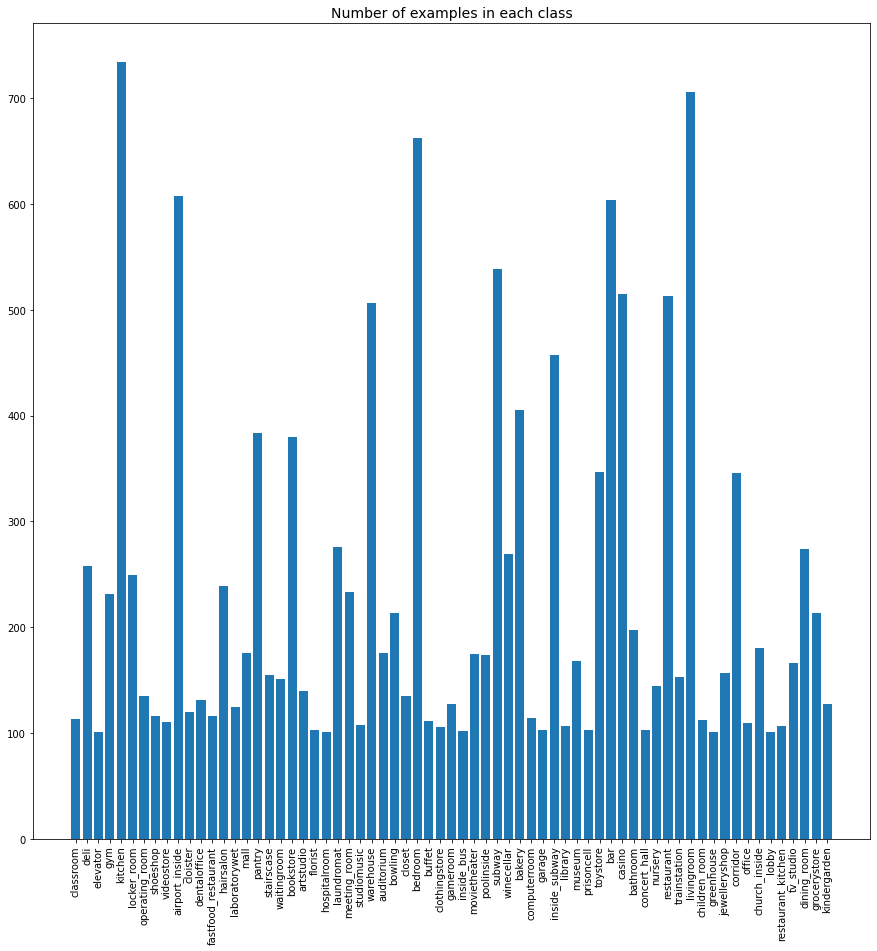

In [10]:
plt.figure(figsize=(15, 15))
plt.bar(cls_name, cls_num)
# plt.ylabel()
# plt.yticks()
plt.xticks(rotation='vertical') 
plt.title("Number of examples in each class")
plt.show()         

### Number of images in each class

### Image size distribution 
1. average size
2. maximum size 
3. minimum size

In [11]:
avg_num = sum(cls_num) / len(cls_num)
avg_num

233.13432835820896

In [12]:
max_num = max(cls_num)
max_num

734

In [13]:
min_num = min(cls_num)
min_num

101

In [14]:
num_sample_over_200 = sum([i >= 200 for i in cls_num]) 
print('{} classes in dataset have more 200 samples.'.format(num_sample_over_200))

25 classes in dataset have more 200 samples.


In [15]:
num_sample_over_300 = sum([i >= 300 for i in cls_num]) 
print('{} classes in dataset have more 300 samples.'.format(num_sample_over_300))

15 classes in dataset have more 300 samples.


In [16]:
num_sample_over_400 = sum([i >= 400 for i in cls_num]) 
print('{} classes in dataset have more 400 samples.'.format(num_sample_over_400))

11 classes in dataset have more 400 samples.


## Split data - Train / Test 

In [17]:
train_txt = base_dir + 'TrainImages.txt'
test_txt = base_dir + 'TestImages.txt'

In [18]:
train_txt

'./data/TrainImages.txt'

In [19]:
org_train_paths = []
train_classes =[]
org_test_paths = []
test_classes = []

In [20]:
with open(train_txt) as f:
    lines = f.readlines() 
    for line in lines:
        org_train_paths.append(line.strip()) 
        train_classes.append(line.split('/')[0])
print(len(org_train_paths))

5360


In [21]:
with open(test_txt) as f:
    lines = f.readlines() 
    for line in lines:
        org_test_paths.append(line.strip()) 
        test_classes.append(line.split('/')[0])
print(len(org_test_paths))

1340


In [22]:
# test_classes[:10]

In [23]:
full_train_paths = [ data_dir + path for path in org_train_paths] 
full_test_paths = [ data_dir + path for path in org_test_paths] 

In [24]:
len(full_train_paths)

5360

In [25]:
train_img_width = []
train_img_height = [] 
train_img_mode = [] 
train_img_aspect_ratio = [] 
test_img_width = []
test_img_height = []
test_img_mode = [] 
test_img_aspect_ratio = [] 

In [26]:
for path in full_train_paths:
    img = Image.open(path)
    train_img_width.append(img.size[0])
    train_img_height.append(img.size[1])
    train_img_mode.append(str(img.mode))
    train_img_aspect_ratio.append(round(img.size[0] / img.size[1], 2)) 

In [27]:
len(train_img_aspect_ratio)

5360

In [28]:
img = load_img(full_train_paths[1])

In [92]:
len(full_train_paths), type(full_train_paths), type(full_train_paths[1]) 

(5360, list, str)

In [93]:
len(train_img_mode), type(train_img_mode), type(train_img_mode[1]) 

(5360, list, str)

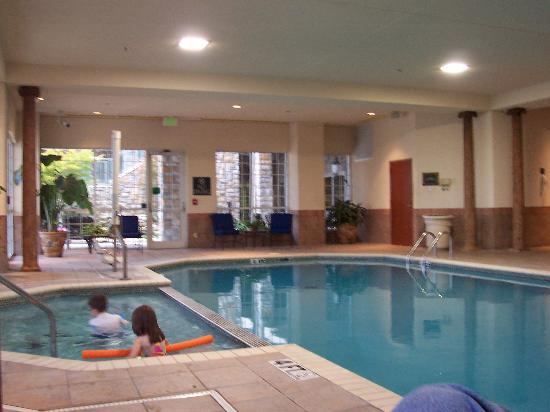

In [94]:
img

In [95]:
for path in full_test_paths:
    img = Image.open(path)
    test_img_width.append(img.size[0])
    test_img_height.append(img.size[1])
    test_img_mode.append(str(img.mode))
    test_img_aspect_ratio.append(round(img.size[0] / img.size[1], 2)) 

In [96]:
len(test_img_width)

1340

In [97]:
cols = ['path' , 'classes', 'img_mode', 'width', 'height', 'aspect_ratio']
len_train = len(full_train_paths) 
train_indices = list(range(len_train))

In [98]:
len_test = len(full_test_paths) 
test_indices = list(range(len_test)) 

In [99]:
train_df = pd.DataFrame(columns=cols, data = np.zeros((len_train, len(cols))))
test_df = pd.DataFrame(columns=cols, data=np.zeros((len_test, len(cols)))) 

In [100]:
train_df.path, train_df.classes, train_df.img_mode, train_df.width, train_df.height, train_df.aspect_ratio = \
full_train_paths, train_classes, train_img_mode, train_img_width, train_img_height, train_img_aspect_ratio

In [101]:
train_df['img_size'] = train_df.width * train_df.height

In [102]:
train_df.head()

,path,classes,img_mode,width,height,aspect_ratio,img_size
0,./data/indoorCVPR_09/Images/gameroom/bt_132294...,gameroom,RGB,397,296,1.34,117512
1,./data/indoorCVPR_09/Images/poolinside/inside_...,poolinside,RGB,550,412,1.33,226600
2,./data/indoorCVPR_09/Images/winecellar/bodega_...,winecellar,RGB,500,375,1.33,187500
3,./data/indoorCVPR_09/Images/casino/casino_0512...,casino,RGB,400,258,1.55,103200
4,./data/indoorCVPR_09/Images/livingroom/living5...,livingroom,RGB,1024,768,1.33,786432


In [103]:
train_df.to_csv('train_stats.csv') 

In [104]:
test_df.path, test_df.classes, test_df.img_mode, test_df.width, test_df.height, test_df.aspect_ratio = \
full_test_paths, test_classes, test_img_mode, test_img_width, test_img_height, test_img_aspect_ratio

In [105]:
test_df['img_size'] = test_df.width * test_df.height

In [106]:
test_df.head()

,path,classes,img_mode,width,height,aspect_ratio,img_size
0,./data/indoorCVPR_09/Images/kitchen/int474.jpg,kitchen,RGB,256,256,1.00,65536
1,./data/indoorCVPR_09/Images/operating_room/ope...,operating_room,RGB,260,209,1.24,54340
2,./data/indoorCVPR_09/Images/restaurant_kitchen...,restaurant_kitchen,RGB,470,351,1.34,164970
3,./data/indoorCVPR_09/Images/videostore/videocl...,videostore,RGB,375,500,0.75,187500
4,./data/indoorCVPR_09/Images/poolinside/piscine...,poolinside,RGB,460,369,1.25,169740


### Explore the image size and aspect ratio

<AxesSubplot:ylabel='Frequency'>

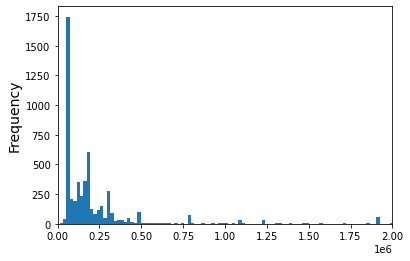

In [107]:
train_df.img_size.plot.hist(bins=500, xlim=(0, 0.2*1e7))

In [108]:
train_df.img_size.argmax()

991

In [109]:
train_df.width[train_df.img_size.argmax()]

3888

In [110]:
train_df.height[train_df.img_size.argmax()]

2592

In [111]:
train_df.width[train_df.img_size.argmin()]

130

In [112]:
train_df.height[train_df.img_size.argmin()]

96

In [113]:
train_df.width.mean() 

499.87630597014925

In [114]:
train_df.height.mean()

412.3981343283582

<AxesSubplot:ylabel='Frequency'>

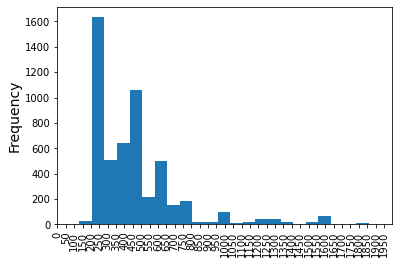

In [115]:
train_df.width.plot.hist(bins=50, xlim=(0, 2000), xticks=list(range(0, 2000, 50)), rot=90)

<AxesSubplot:ylabel='Frequency'>

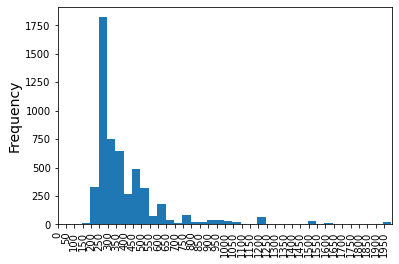

In [116]:
train_df.height.plot.hist(bins=50, xlim=(0, 2000), xticks=list(range(0, 2000, 50)), rot=90)

<AxesSubplot:ylabel='Frequency'>

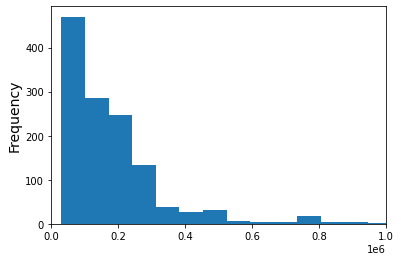

In [117]:
test_df.img_size.plot.hist(bins=100, xlim=(0, 0.1*1e7)) 

<AxesSubplot:ylabel='Frequency'>

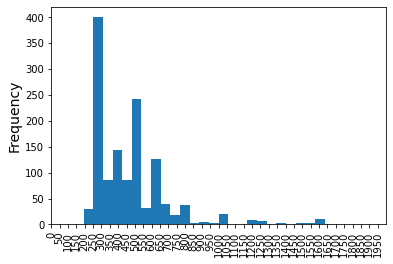

In [118]:
test_df.width.plot.hist(bins=50, xlim=(0, 2000), xticks=list(range(0, 2000, 50)), rot=90)

<AxesSubplot:ylabel='Frequency'>

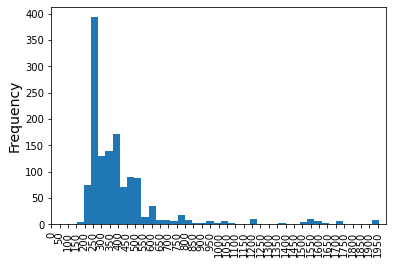

In [119]:
test_df.height.plot.hist(bins=50, xlim=(0, 2000), xticks=list(range(0, 2000, 50)), rot=90)

<AxesSubplot:ylabel='Frequency'>

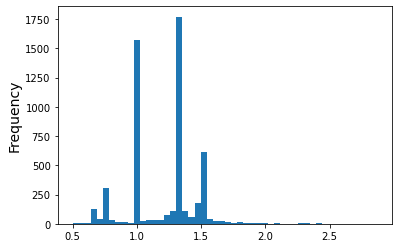

In [120]:
train_df.aspect_ratio.plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

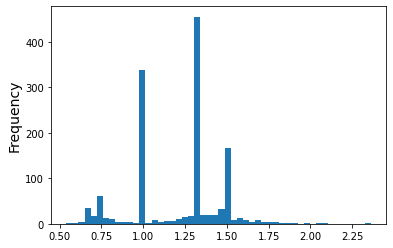

In [121]:
test_df.aspect_ratio.plot.hist(bins=50)

### Split data according to ... 

In [122]:
train_df = pd.read_csv('train_stats.csv')

In [123]:
test_df = pd.read_csv('test_stats.csv')

In [124]:
test_df['organized_path'] = test_df['path'].map(lambda x: ('/').join(x.split('/') [-2:]))
test_df.organized_path = test_df['organized_path'].map(lambda x: test_dir + x)

In [125]:
test_df.organized_path

0                          ./data/test/kitchen/int474.jpg
1       ./data/test/operating_room/operating_room_31_0...
2       ./data/test/restaurant_kitchen/restaurant_kitc...
3       ./data/test/videostore/videoclub_05_14_flickr.jpg
4         ./data/test/poolinside/piscine_interieureee.jpg
                              ...                        
1335    ./data/test/locker_room/locker_room_google_010...
1336                    ./data/test/corridor/IMG_9660.jpg
1337                   ./data/test/studiomusic/int774.jpg
1338                    ./data/test/cloister/20188429.jpg
1339    ./data/test/bookstore/Librairie_49_01_altavist...
Name: organized_path, Length: 1340, dtype: object

In [126]:
train_dir = './data/train/' 
test_dir =  './data/test/'

In [127]:
train_cls_dirs = [ train_dir + i + '/' for i in classes]
test_cls_dirs =  [test_dir + i + '/' for i in classes] 

In [128]:
# test_cls_dirs

In [44]:
for directory in  train_cls_dirs:
     if not os.path.exists(directory):
        os.mkdir(directory)
        
for directory in  test_cls_dirs:
     if not os.path.exists(directory):
        os.mkdir(directory)

In [50]:
train_df['organized_path'] = train_df['path'].map(lambda x: ('/').join(x.split('/') [-2:]))

In [51]:
train_df.organized_path = train_df['organized_path'].map(lambda x: train_dir + x)

In [7]:
# for train_df.path 

In [6]:
import shutil

In [59]:
for org_path, path in zip(train_df.path, train_df.organized_path):
    shutil.copyfile(org_path, path)

In [60]:
for org_path, path in zip(test_df.path, test_df.organized_path):
    shutil.copyfile(org_path, path)

## Keras Models without Finetune

In [5]:
data_augmentation = Sequential(
  [
    layers.Resizing(configs.augment_config['img_resize'], configs.augment_config['img_resize']),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomFlip("horizontal_and_vertical"),

    layers.RandomRotation(configs.augment_config['random_ratio']),
    layers.CenterCrop(configs.augment_config['img_crop'], configs.augment_config['img_crop']),
    layers.RandomZoom(configs.augment_config['random_ratio']),
    # layers.RandomBrightness(configs.img_factor),
    layers.RandomContrast(configs.augment_config['img_factor']),
    layers.RandomTranslation(configs.augment_config['img_factor'], configs.augment_config['img_factor']),
    RandomGray(configs.augment_config['random_ratio']),
  ]
)

In [7]:
class BasicBlock(layers.Layer):
    
    expansion = 1
    
    def __init__(self, out_channels, strides=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__(**kwargs)
        self.conv1 = Conv2D(out_channels, 3, padding='same', strides=strides, use_bias=False)
        self.bn1 = BatchNormalization(momentum=0.9, epsilon=1e-5)
        self.conv2 = Conv2D(out_channels, 3, padding='same', strides=1, use_bias=False)
        self.bn2 = BatchNormalization(momentum=0.9, epsilon=1e-5)
        self.relu = layers.ReLU()
        self.add = layers.Add()
        self.downsample = downsample 
        
    def call(self, inputs, training=False):
        identity = inputs 
        if self.downsample is not None:
            identity = self.downsample(inputs) 
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.relu(x)
        
        x = self.add([identity, x])
        x = self.relu(x)
        return x        

In [8]:
# In bottelneck structure, we are not going to use unified number of output channels
# We actually expand the output channels by 
class Bottleneck(layers.Layer):
    
    expansion = 4 
    
    def __init__(self,out_channels, strides=1, downsample=None, **kwargs):
        super(Bottleneck).__init__(**kwargs)
        self.conv1 = Conv2D(out_channels, 3,  padding='same', use_bias=False, name='conv1')
        self.bn1 = BatchNormalization(momentum=0.9, epsilon=1e-5, name='conv1/BatchNorm')
        self.conv2 = Conv2D(out_channels, 3, padding='same', use_bias=False, name='conv2')
        self.bn2 = BatchNormalization(momentum=0.9, epsilon=1e-5, name='conv2/BatchNorm')
        self.conv3 = Conv2D(out_channels*self.expansion, 1, padding='same', use_bias=False, name='conv3')
        self.bn3 = BatchNormalization(momentum=0.9, epsilon=1e-5, name='conv3/BatchNorm')
        self.relu = layers.ReLU() 
        self.add = layers.Add()
        self.downsample = downsample
        
    def call(inputs, training=False):
        identity = inputs 
        if self.downsample is not None:
            identity = self.downsample(inputs) 
            
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x, training=training)
        
        x = self.add([identity, x]) 
        x = self.relu(x)
        
        return x                

In [ ]:
# Using funcitonal API to build network structure 
def _make_layer(block, in_channel, channel, block_num, name, strides=1):
    downsample = None
    if strides != 1 or in_channel !=  channel*block.expansion:
        downsample = Sequential([
                                layers.Conv2D(channel, kernel_size=1, strides=strides, use_bias=False, name='conv1'),
                                layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='BatchNorm')
                                ], name = 'shortcut')
    layer_list = [] 
    layer_list.append(block(channel, downsample=downsample, strides=strides, name='unit_0'))
    for index in range(block_num):
        layer_list.append(block(channel, name='unit_' + str(index+1)))  # downsample=None, strides=1
    
    return Sequential=(layer_list, name=name)
        
    
def _resnet(block, blocks_num, im_width=224, im_height=224, num_classes=1000, include_top=True):
    input_image = layers.Input(shape=(im_width, im_height, 3), dtype='float32')
    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False, name='conv1')(input_image)
    x = _make_layer(block, block_num[0], x.shape[-1], 64, name='block1')(x)
    x = _make_layer(block, block_num[1], x.shape[-1], 128, strides=2, name='block2')(x)
    x = _make_layer(block, block_num[2], x.shape[-1], 256, strides=2, name='block3')(x)
    x = _make_layer(block, block_num[3], x.shape[-1], 512, strides=2, name='block4')(x) 
    
    if include_top:
        x = layers.GlobalAvgPool2D()(x)  # pool + flatten
        x = layers.Dense(num_classes, name="logits")(x)
        predict = layers.Softmax()(x)
    else:
        predict = x

    model = Model(inputs=input_image, outputs=predict)
    
    return 
    

In [167]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

# Plot the training and validation loss + accuracy
def plot_training(history):
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt

    #Accuracy plot
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','val'], loc='upper left')
    plt.title('Training and validation accuracy')
    plt.savefig('fine_tuning_accuracy.pdf')
    plt.close()
    #Loss plot
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','val'], loc='upper left')
    plt.title('Training and validation loss')
    plt.savefig('fine_tuning_loss.pdf')



img_width, img_height = 256, 256
train_data_dir = "/gpfs/projects/nct00/nct00038/mit67/train"
validation_data_dir = "/gpfs/projects/nct00/nct00038/mit67/test"
nb_train_samples = 5359
nb_validation_samples = 1339 
batch_size = 128
epochs = 10
target_classes = 67

model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

# Freeze the layers which you don't want to train. Here I am freezing the first 10 layers.
for layer in model.layers[:10]:
    layer.trainable = False

#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(67, activation="softmax")(x)

# creating the final model 
model_final = Model(model.input, predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])


# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(
        rescale = 1./255)#,
        #horizontal_flip = True,
        #fill_mode = "nearest",
        #zoom_range = 0.3,
        #width_shift_range = 0.3,
        #height_shift_range=0.3,
        #rotation_range=30)

val_datagen = ImageDataGenerator(
        rescale = 1./255)#,
        #horizontal_flip = True,
        #fill_mode = "nearest",
        #zoom_range = 0.3,
        #width_shift_range = 0.3,
        #height_shift_range=0.3,
        #rotation_range=30)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size = (img_height, img_width),
        batch_size = batch_size, 
        class_mode = "categorical")

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size = (img_height, img_width),
        batch_size = batch_size,
        shuffle = False, 
        class_mode = "categorical")

# Save the model according to the conditions  
#checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

# Train the model 
history = model_final.fit_generator(
        train_generator,
        steps_per_epoch = nb_train_samples//batch_size,
        epochs = epochs,
        validation_data = validation_generator,
        validation_steps=nb_validation_samples//batch_size,
        callbacks = [early])#,checkpoint])

plot_training(history)

2022-11-05 11:40:25.982909: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-05 11:40:26.882674: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22310 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:56:00.0, compute capability: 8.6


58889256/58889256 [==============================] - 2s 0us/step


/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/projects/nct00/nct00038/mit67/train'

In [ ]:
import os
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from fne import full_network_embedding

if __name__ == '__main__':
    # This shows an example of calling the full_network_embedding method using
    # the VGG16 architecture pretrained on ILSVRC2012 (aka ImageNet), as
    # provided by the keras package. Using any other pretrained CNN
    # model is straightforward.

    # Load model
    img_width, img_height = 224, 224
    initial_model = tf.keras.applications.VGG16(weights="imagenet", include_top=True,
                                                input_shape=(img_width, img_height, 3))
    target_layer_names = ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2',
                          'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2',
                          'block5_conv3', 'fc1', 'fc2']
    
    # Define data splits
    # Train set
    train_path = '/gpfs/projects/nct00/nct00038/mit67/train/'
    train_images = []
    train_labels = []
    # Use a subset of classes to speed up the process. -1 uses all classes.
    num_classes = 3
    for train_dir in os.listdir(train_path):
        train_dir_path = os.path.join(train_path, train_dir)
        for train_img in os.listdir(train_dir_path):
            train_images.append(os.path.join(train_dir_path, train_img))
            train_labels.append(train_dir)
        num_classes -= 1
        if num_classes == 0:
            break
    # Test set
    test_path = '/gpfs/projects/nct00/nct00038/mit67/test/'
    test_images = []
    test_labels = []
    num_classes = 3
    for test_dir in os.listdir(test_path):
        test_dir_path = os.path.join(test_path, test_dir)
        for test_img in os.listdir(test_dir_path):
            test_images.append(os.path.join(test_dir_path, test_img))
            test_labels.append(test_dir)
        num_classes -= 1
        if num_classes == 0:
            break

    print('Total train images:', len(train_images), ' with their corresponding', len(train_labels), 'labels')
    print('Total test images:', len(test_images), ' with their corresponding', len(test_labels), 'labels')

    # Parameters for the extraction procedure
    batch_size = 128
    input_reshape = (224, 224)
    # Call FNE method on the train set
    fne_features, fne_stats_train = full_network_embedding(initial_model, train_images, batch_size,
                                                           target_layer_names, input_reshape)
    print('Done extracting features of training set. Embedding size:', fne_features.shape)

    from sklearn import svm

    # Train SVM with the obtained features.
    clf = svm.LinearSVC()
    clf.fit(X=fne_features, y=train_labels)
    print('Done training SVM on extracted features of training set')

    # Call FNE method on the test set, using stats from training
    fne_features, fne_stats_train = full_network_embedding(initial_model, test_images, batch_size,
                                                           target_layer_names, input_reshape, stats=fne_stats_train)
    print('Done extracting features of test set')

    # Test SVM with the test set.
    predicted_labels = clf.predict(fne_features)
    print('Done testing SVM on extracted features of test set')

    # Print results
    print(classification_report(test_labels, predicted_labels))
    print(confusion_matrix(test_labels, predicted_labels))

## Hyperparameters Setting

In [32]:
train_dir = './data/train/'
test_dir = './data/test/'
BATCH_SIZE = 16 
IMG_SIZE = 256 
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3) 

### Resnet50

In [37]:
preprocess_input = tf.keras.applications.resnet.preprocess_input
# rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [38]:
preprocess_input

<function keras.applications.resnet.preprocess_input(x, data_format=None)>

In [39]:
batch_inputs = tf.random.normal((BATCH_SIZE, 256, 256, 3))

In [40]:
keras.applications.resnet50.ResNet50 

<function keras.applications.resnet.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, **kwargs)>

In [41]:
base_model = keras.applications.resnet50.ResNet50(include_top=False, 
                                                  weights="imagenet",
                                                  input_tensor=None,
                                                  input_shape=INPUT_SHAPE,
                                                  pooling=None,
                                                  # classes=1000,
                                                 )


In [68]:
base_model.trainable = False

In [42]:
target_layer_names = ['conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']

In [43]:
target_block_names = ['', '', '']

In [44]:
base_model.layers[10].output

<KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'conv2_block1_2_conv')>

In [45]:
type(base_model)

keras.engine.functional.Functional

In [46]:
 feature_extractor = tf.keras.Model(
        inputs=base_model.inputs,
        outputs=[layer.output for layer in base_model.layers if layer.name in target_layer_names],
    )

In [47]:
outputs = feature_extractor.output

In [48]:
x1 =  GlobalAveragePooling2D()(outputs[0])
x2 =  GlobalAveragePooling2D()(outputs[1])

In [49]:
outputs[1].shape

TensorShape([None, 32, 32, 512])

In [50]:
x = Concatenate(axis=-1)([x1, x2])

In [51]:
out = tf.keras.layers.Dense(10)(x) 

In [52]:
whole_model =  tf.keras.Model(
        inputs=base_model.inputs,
        outputs=out 
    )

In [53]:
# whole_model(batch_inputs)

In [ ]:
len(model.trainable_variables)

In [54]:
resnet50_layer_names = [base_model.layers[i].name for i in range(len(base_model.layers))]

In [56]:
resnet50_output_names = [outlayer for outlayer in resnet50_layer_names if 'out' in outlayer]

In [58]:
 feature_extractor_large = tf.keras.Model(
        inputs=base_model.inputs,
        outputs=[layer.output for layer in base_model.layers if layer.name in resnet50_output_names],
    )

In [60]:
len(feature_extractor_large.output)

16

### 有个想法, 就是每个大的block内部的concate，然后再走global average pooling 

In [55]:
target_layer_names = ['conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']

In [19]:
conv_out_indicies = [0, 7]

In [22]:
for name in conv_out_namelst:
    idx = layer_names.index(name) + 1 
    conv_out_indicies.append(idx)
conv_out_indicies     

[0, 7, 39, 81, 143, 175]

In [28]:
res_block1  = base_model(batch_inputs) 

In [27]:
# dir(base_model)

In [211]:
weight = tf.random.normal(
    (3, 3, 64, 64),
    # mean=0.0,
    # stddev=1.0,
    # dtype=tf.dtypes.float32,
    # seed=None,
    # name=None
)

In [214]:
base_model.layers[10].weights[1] = weight

In [62]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=(IMG_SIZE,IMG_SIZE))

Found 5361 files belonging to 67 classes.


In [64]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=(IMG_SIZE,IMG_SIZE))

Found 1340 files belonging to 67 classes.


**As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.**

In [67]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [66]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

####  这个小小的block 故事很多！！

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)  # training = False 
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
class ResNet50FeatureExtractor(tf.keras.Model):

    def __init__(self, num_classes=1000):
        super(ResNet, self).__init__()
        self.block_1 = ResNetBlock()
        self.block_2 = ResNetBlock()
        self.global_pool = layers.GlobalAveragePooling2D()
        self.classifier = Dense(num_classes)

    def call(self, inputs):
        x = self.block_1(inputs)
        x = self.block_2(x)
        x = self.global_pool(x)
        return self.classifier(x)


resnet = ResNet()
dataset = ...
resnet.fit(dataset, epochs=10)
resnet.save(filepath)

## Pretrain and finetune

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input 

### EfficientNet

### places365 Pretrain

## Vision Transformers

## Openmmlab

## Detectron2 Model Zoo and Baselines (Imagenet or COCO)

## Pretrain & Finetune

### Freeze
Freeze all feature extraction, Adding classification head, Train from Scratch. 

Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

### Finetune
Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. **Notice: different learning rate should be applied!**

### Freeze and Finetune
Firstly freeze all the feature extractor train classifer from scratch, then unfreeze the top layers and finetune them together! 

## Reference 

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [12]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [9]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

TypeError: Exception encountered when calling layer "center_crop_1" (type CenterCrop).

Expected int32 passed to parameter 'y' of op 'Sub', got 0.2 of type 'float' instead. Error: Expected int32, but got 0.2 of type 'float'.

Call arguments received by layer "center_crop_1" (type CenterCrop):
  • inputs=tf.Tensor(shape=(None, 200, 200, 3), dtype=float32)

All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [11]:
base_model.trainable = True

NameError: name 'base_model' is not defined

When you set layer.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.
When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.